# A Learning-based Model for Assessment of Recurrent Abortion
## Import library, define some useful function

In [1]:
# basic
import warnings
import pickle
import json
from functools import partial
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

# classifiers
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# spliting
from sklearn.model_selection import train_test_split, StratifiedKFold

# metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, confusion_matrix

# statistical tools
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency

# visualization
from IPython.display import display, IFrame,Image
import shap
import tensorboardX
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
sns.set(style="whitegrid", context="paper", font="sans-serif",
        rc={'figure.figsize': (5, 5), 'figure.dpi': 1200, "font.size": 12, "axes.titlesize": 11,
            "axes.labelsize": 10})

# fix random seed for reproducebility
SEED=8888

# it takes some time to run cross validation, turn off if you don't need it
RUN_CV_RESULT = True
CV_RESULT_REPEAT = 25

VAR_NUM = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

COMPARED_METHOD = [
    "XGBoost",
    "Logistic",
    "Random Forest",
    "SVM",
    "Decision Tree",
    "LDA"
]

# variables
VARS_ALL = \
    {
        "num": ['年龄', '体重/KG', '身高/cm', 'BMI/kg^m3', '孕次', '产次', '剖宫产次', '顺产次', '引产次', '自然流产次数', 
                 '初潮', 'FSH','FT4', 'LH', 'E2', 'P', 'PRL', 'T', 'IN', 'TSH', 'TT3', 'TT4', 'TPOAb', '糖化', '未孕(0h/', 
                '1h/', '2h/', 'FT3', '抗心磷脂抗体IgG', '抗心磷脂抗体IgM', '抗β2糖蛋白I抗体IgG', '抗核抗体筛查', 
                 'NK细胞', '狼疮抗凝物（LA）', '色谱法同型半胱氨酸测定', '蛋白C测定', '蛋白S测定', 'D二聚体', 
                'PT', 'ATIII' ]
,
        
        "cate": ['是否治疗', '是否转阳*', '流产期', '清宫', '妇科疾病史', 'UU-F', '梅毒-F', 'CT-F', 'HIV-F', 
                 'TORCH-F', 'B19微小病毒-F', '既往月经周期*', '经量', '痛经', '丈夫情况*', 'Infection Score', 'Infertility-related SCORE',
                 'FSH-F', 'LH-F2', 'E2-F2', 'P-F2', 'PRL-F2', 'T-F2', 'IN-F2', 'TSH-F2', 'TT3-F2', 'TT4-F2', 
                 'FT3-F2',  'FT4-F2',  'TPOAb-F2', '糖化-F2', '未孕(0h-F2', '1h-F2', '2h-F2', '抗心磷脂抗体-F', 
                 '抗子宫内膜抗体-F', '抗卵巢抗体-F', '抗精子抗体-F', '抗心磷脂抗体IgG-F', '抗心磷脂抗体IgM-F', 'APS SCORE',
                 '抗β2糖蛋白I抗体IgG-F', '抗核抗体筛查-F', 'NK细胞-F3', '狼疮抗凝物（LA）-F3', '色谱法同型半胱氨酸测定-F3',
                 '蛋白C测定-F3', '蛋白S测定-F3', 'D二聚体-F3', 'PT-F3', 'AT-III-F', '支原体-F', '衣原体-F', '血常规-F', 
                 '凝血-F2', '肝肾功能-F2', '血糖-F', '血脂-F', '血液免疫常规-F', '胚胎染色体有无异常', '男方外周血染色体有无异常', 
                 '女方外周染色体有无异常', '血型(+/-)', '血型（ABO)']
    }

# compared METHODS
METHODS = [
    {
        "name": "XGBoost",
        "hyper_parameters": {'alpha': 4.0, 'colsample_bytree': 0.9, 'eta': 0.25, 'gamma': 1, 'lambda': 2,
                             'max_depth': 8, 'min_child_weight': 7.0, 'scale_pos_weight': 20.0,
                             'subsample': 0.9,
                             'n_estimators': 120,"random_state":SEED},
        "classifier": XGBClassifier
    },
    {
        "name": "FeatureImportance",
        "hyper_parameters": {'max_depth': 4, 'learning_rate': 0.2, 'reg_lambda': 1, 'n_estimators': 150,
                             'subsample': 0.9, "colsample_bytree": 0.9},
        "classifier": XGBClassifier
    },
    {
        "name": "Logistic",
        "hyper_parameters": {
            "penalty": 'l2'},
        "classifier": LogisticRegression
    },
    {
        "name": "Random Forest",
        "hyper_parameters": {"criterion": "entropy"},
        "classifier": RandomForestClassifier
    },
    {
        "name": "SVM",
        "hyper_parameters": {"kernel": "rbf"},
        "classifier": SVC
    },
    {
        "name": "Decision Tree",
        "hyper_parameters": {'max_depth': 3, 'n_estimators': 1},
        "classifier": XGBClassifier
    },
    {
        "name": "LDA",
        "hyper_parameters": {},
        "classifier": LinearDiscriminantAnalysis
    },

]

# utility functions
sensitivity=lambda y_true, y_pred:classification_report(y_true, y_pred, output_dict=True, target_names=["Non_Server", "Server"])["Server"]["recall"]
specifity=lambda y_true, y_pred:classification_report(y_true, y_pred, output_dict=True, target_names=["Non_Server", "Server"])["Non_Server"]["recall"]
TN=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[0]
FP=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[1]
FN=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[2]
TP=lambda y_true, y_pred:confusion_matrix(y_true, y_pred).ravel()[3]
def q25(x):
    return np.quantile(x, q=0.25)
def q75(x):
    return np.quantile(x, q=0.75)


# compared metrics
MY_METRICS = {
    # commented metrics not used because of limited space and selected metrics are sufficient to estimate the performance

    # "F1_binary": partial(f1_score, average="binary"),
    # "F1_macro": partial(f1_score, average="macro"),
    "F1_weighted": partial(f1_score, average="weighted"),
    # "Precision_binary": partial(precision_score, average="binary"),
    # "Precision_macro": partial(precision_score, average="macro"),
    # "Precision_weighted": partial(precision_score, average="weighted"),
    # "Recall_binary": partial(recall_score, average="binary"),
    # "Recall_macro": partial(recall_score, average="macro"),
    # "Recall_weighted": partial(recall_score, average="weighted"),
    "Accuracy": accuracy_score,
    "Sensitivity": sensitivity,
    "Specifity": specifity,
    "tn": TN,
    "fp": FP,
    "fn": FN,
    "tp": TP,
}

# METHODS of which AUC can be calculated
HAVE_AUC_METHOD = [
    "XGBoost",
    "Logistic",
    "Random Forest",
    "Decision Tree",
    "LDA"]


## Loading data


In [24]:

# load dataset
dataset = pd.read_excel("./FOR CODE-V5.0-all indexes.xlsx", sheet_name='FOR CODE', convert_float=False)
dataset = dataset.drop(['编号', '门诊号', 'BA', '姓名', '电话', '时间'],axis=1)
for i in list(dataset.columns):
    if dataset[i].dtypes == 'object':
        dataset[i] = pd.to_numeric(dataset[i], errors='coerce')
print(dataset.info())
# dataset_non_tranmit = dataset[dataset.non_severe_to_severe != 1]
y = "是否分娩"
ALL_X = [*VARS_ALL["num"], *VARS_ALL["cate"]]
# make table_1 to show statistics
table_1 = pd.DataFrame()
for var in VARS_ALL["num"]:
    t ={}
    t["var"] = var
    t["support"] = len(dataset[var].dropna())
    t["mean"] = dataset[var].astype(float).dropna().mean()
    t["std"] = dataset[var].astype(float).dropna().std()
    table_1 = table_1.append(t,ignore_index=True)
    
for var in VARS_ALL["cate"]:
    t = {}
    t["var"] = var
    t["support"] = len(dataset[[var,y]].dropna())
    for cat in list(dataset[[var,y]].dropna()[var].unique()):
        t[str(int(cat))] = len(dataset[[var,y]].dropna()[dataset[[var,y]].dropna()[var]==1])
        t[str(int(cat)) + 'ratio'] = t[str(int(cat))] / len(dataset[[var,y]])
    table_1 = table_1.append(t,ignore_index=True)
# display(table_1)
table_1.to_csv("./Table_1.csv", encoding="utf_8_sig")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Columns: 105 entries, 是否治疗 to 血液免疫常规-F
dtypes: float64(105)
memory usage: 1.5 MB
None


## Missing Value


,Number of Observations,Number of Variables,Thresh alpha
0,0.0,105.0,0.0
1,0.0,105.0,1.0
2,0.0,105.0,2.0
3,0.0,105.0,3.0
4,0.0,105.0,4.0
...,...,...,...
1870,1875.0,3.0,1870.0
1871,1875.0,3.0,1871.0
1872,1875.0,3.0,1872.0
1873,1875.0,3.0,1873.0


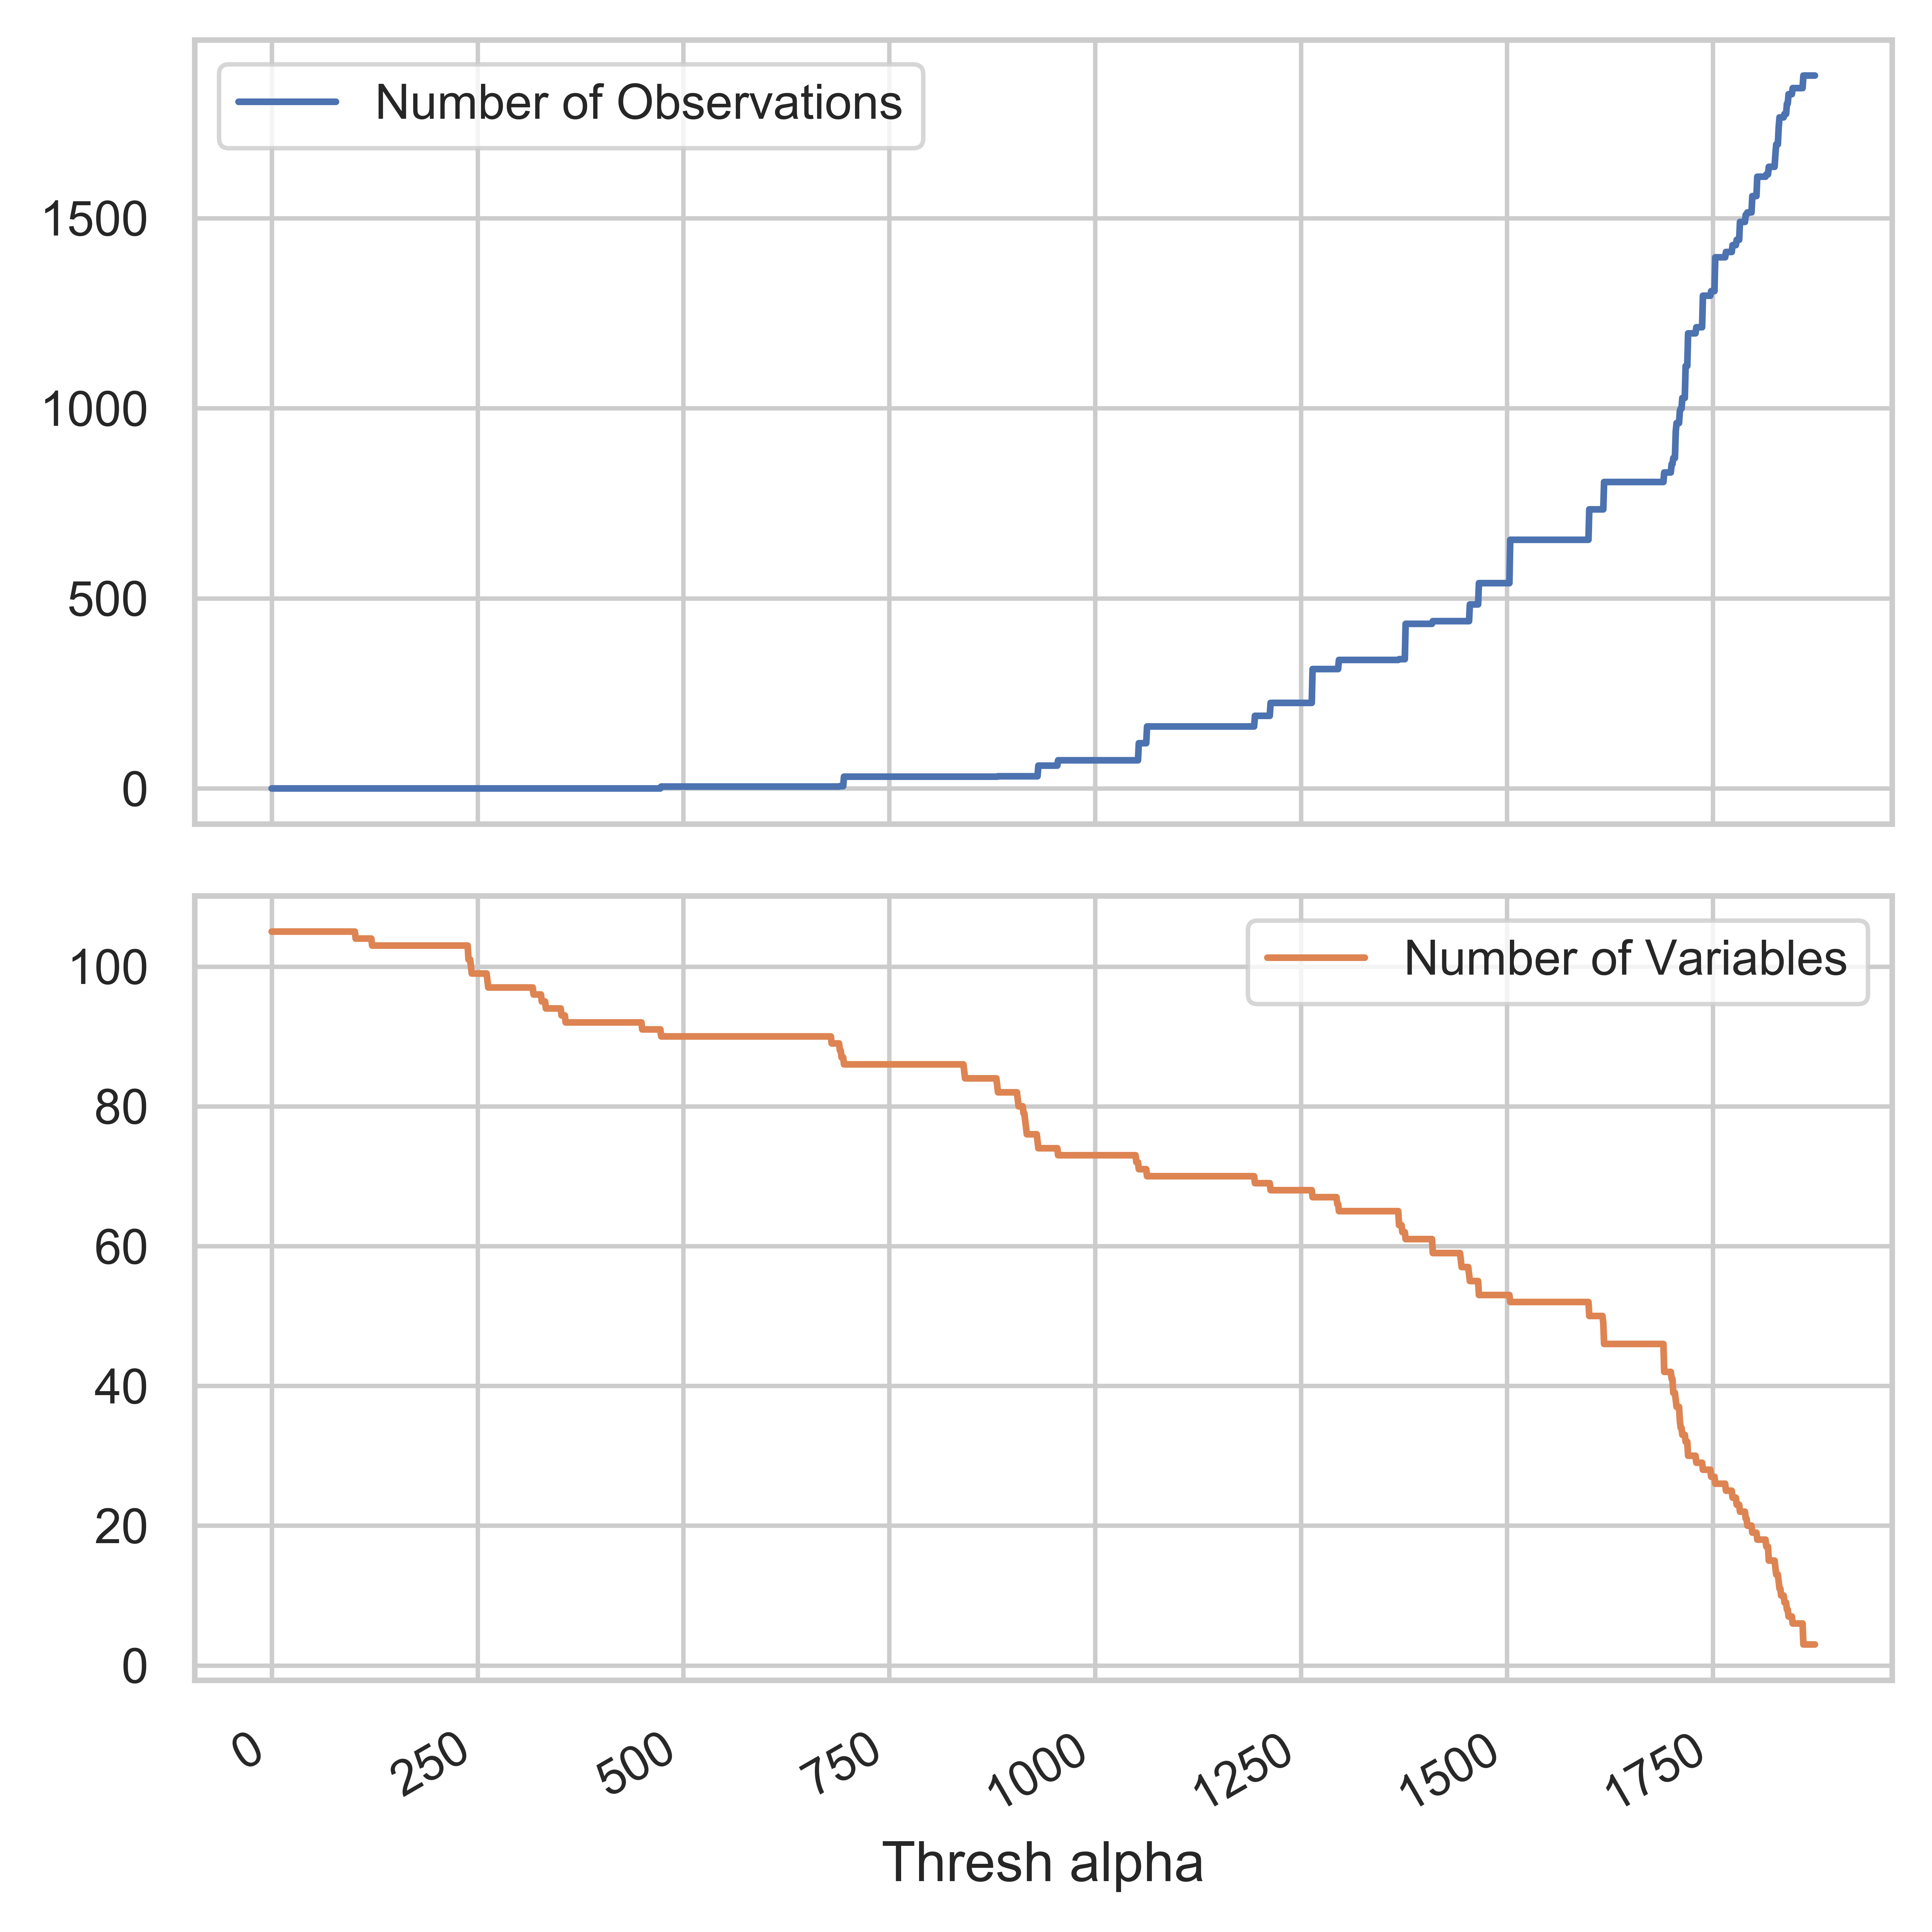

In [75]:
# show the relationship between included variables and available observations
obs_vars_alpha = pd.DataFrame()
for i in range(1875):
    t = dataset[[*ALL_X, y]].dropna(axis="columns", thresh=i).dropna()
    obs_vars_alpha = obs_vars_alpha.append(
        {
            "Thresh alpha": i,
            "Number of Observations": len(t),
            "Number of Variables": len(t.columns)
        }, ignore_index=True)
display(obs_vars_alpha)
obs_vars_alpha.plot(x="Thresh alpha", y=["Number of Observations", "Number of Variables"], subplots=True)
plt.tight_layout()
# plt.show()
plt.savefig("./Figure_alpha_selection.png")
# Image(filename="./paper/Supplementary_Figure_2.png")
# plt.clf()
# plt.close()


In [78]:
# remove missing value
# display(obs_vars_alpha[1690:1750])
THRESHOLD_ALPHA=1699 # the THRESHOLD_ALPHA is determined from above figure
VARS_REMOVED_MISSING={}
t = dataset[[*ALL_X, y]].dropna(axis="columns", thresh=THRESHOLD_ALPHA).dropna()
t = t.loc[:, (t != 0).any(axis=0)].loc[:, (t != False).any(axis=0)].loc[:, (t != True).any(axis=0)]
dataset_removing_missing_value=t
display(dataset_removing_missing_value)
dataset_removing_missing_value.to_csv("./dataset_remove_missing_value_thresh_{}.csv".format(THRESHOLD_ALPHA), encoding="utf_8_sig")

VARS_REMOVED_MISSING["num"] = []
VARS_REMOVED_MISSING["cate"] = []
for i in VARS_ALL["num"]:
    if i in list(dataset_removing_missing_value.columns):
        VARS_REMOVED_MISSING["num"].append(i)

for i in VARS_ALL["cate"]:
    if i in list(dataset_removing_missing_value.columns):
        VARS_REMOVED_MISSING["cate"].append(i)

# display(VARS_REMOVED_MISSING)


,年龄,体重/KG,身高/cm,BMI/kg^m3,孕次,产次,剖宫产次,顺产次,引产次,自然流产次数,...,NK细胞-F3,色谱法同型半胱氨酸测定-F3,血常规-F,凝血-F2,肝肾功能-F2,血糖-F,血脂-F,血液免疫常规-F,血型（ABO),是否分娩
0,24.0,40.8,158.0,16.343535,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,27.0,48.0,162.0,18.289895,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
3,35.0,52.5,160.0,20.507812,3.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,25.0,53.0,160.0,20.703125,2.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
18,25.0,50.0,160.0,19.531250,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,32.0,55.0,167.0,19.721037,4.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1869,34.0,60.0,168.0,21.258503,3.0,1.0,1.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0
1870,30.0,57.0,160.0,22.265625,3.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1871,27.0,50.0,166.0,18.144869,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0


{'num': ['年龄',
  '体重/KG',
  '身高/cm',
  'BMI/kg^m3',
  '孕次',
  '产次',
  '剖宫产次',
  '顺产次',
  '引产次',
  '自然流产次数',
  '初潮',
  'TSH',
  'NK细胞',
  '色谱法同型半胱氨酸测定'],
 'cate': ['流产期',
  '清宫',
  '既往月经周期*',
  '经量',
  '痛经',
  'Infertility-related SCORE',
  'TSH-F2',
  '抗心磷脂抗体-F',
  '抗子宫内膜抗体-F',
  '抗卵巢抗体-F',
  '抗精子抗体-F',
  '抗心磷脂抗体IgG-F',
  '抗心磷脂抗体IgM-F',
  'APS SCORE',
  '抗β2糖蛋白I抗体IgG-F',
  '抗核抗体筛查-F',
  'NK细胞-F3',
  '色谱法同型半胱氨酸测定-F3',
  '血常规-F',
  '凝血-F2',
  '肝肾功能-F2',
  '血糖-F',
  '血脂-F',
  '血液免疫常规-F',
  '血型（ABO)']}

## Univariant Statistical Test

In [81]:
# normalty test
normalty_test_result=pd.DataFrame()
for var in dataset_removing_missing_value.columns:
    if var in VARS_REMOVED_MISSING["num"]:
        p_value = shapiro(dataset_removing_missing_value[[var, y]].dropna().astype(float))[1]
        normalty_test_result=normalty_test_result.append(
            {
                "var":var,
                "pvalue":p_value,
                "is_normal":p_value<0.05,
                "num_not_nan":len(dataset_removing_missing_value[[var, y]].dropna().astype(float))
            },ignore_index=True)
print(len(VARS_REMOVED_MISSING["num"]))
print(VARS_REMOVED_MISSING["num"])
display(normalty_test_result)
if len(normalty_test_result)==len(normalty_test_result[normalty_test_result.is_normal==True]):
    print("all_normal")


14
['年龄', '体重/KG', '身高/cm', 'BMI/kg^m3', '孕次', '产次', '剖宫产次', '顺产次', '引产次', '自然流产次数', '初潮', 'TSH', 'NK细胞', '色谱法同型半胱氨酸测定']
all_normal


,is_normal,num_not_nan,pvalue,var
0,1.0,831.0,1.107026e-43,年龄
1,1.0,831.0,8.688050e-44,体重/KG
2,1.0,831.0,0.000000e+00,身高/cm
3,1.0,831.0,2.368194e-43,BMI/kg^m3
4,1.0,831.0,1.765591e-32,孕次
5,1.0,831.0,0.000000e+00,产次
6,1.0,831.0,0.000000e+00,剖宫产次
7,1.0,831.0,0.000000e+00,顺产次
8,1.0,831.0,0.000000e+00,引产次
9,1.0,831.0,1.257826e-33,自然流产次数


In [82]:
# mannwhitneyu-test
uni_test_result = pd.DataFrame()
for var in VARS_REMOVED_MISSING["num"]:
    t = dataset_removing_missing_value[[var, y]].dropna()
    give_birth = t[t[y] == 1][var]
    non_give_birth = t[t[y] == 0][var]
    uni_test_result = uni_test_result.append(
        {"var": var,
         "pvalue": mannwhitneyu(give_birth, non_give_birth)[1],
         "give_birth_mean": give_birth.mean(),
         "give_birth_std": give_birth.std(),
         "non_give_birth_mean": non_give_birth.mean(),
         "non_give_birth_std": non_give_birth.std(),
         "give_birth_count": len(give_birth),
         "non_give_birth_count": len(non_give_birth)
         }
        , ignore_index=True
    )

In [86]:
# chi2test
for var in VARS_REMOVED_MISSING["cate"]:
    ct = pd.crosstab(dataset_removing_missing_value[y], dataset_removing_missing_value[var], margins=True, dropna=True)
    uni_test_result = uni_test_result.append(
        {"var": var,
         "pvalue": chi2_contingency(ct)[1],
         "give_birth_mean": 0,
         "give_birth_std": -1, # indicate it's category variable
         "non_give_birth_mean": 0,
         "non_give_birth_std": 0,
         "give_birth_count": ct.iloc[1, 2] if len(ct.columns) > 1 else 0,
         "non_give_birth_count": ct.iloc[0, 2]
         }
        , ignore_index=True
    )
display(uni_test_result)
uni_test_result.to_csv("./uni_test_result.csv", encoding="utf_8_sig")
significant_vars=uni_test_result[uni_test_result.pvalue<=0.05].sort_values(axis=0, ascending=True, by='pvalue')
display(significant_vars["var"].tolist())


,give_birth_count,give_birth_mean,give_birth_std,non_give_birth_count,non_give_birth_mean,non_give_birth_std,pvalue,var
0,562.0,29.628114,4.052084,269.0,31.338290,4.726953,6.825948e-07,年龄
1,562.0,54.544128,8.176285,269.0,54.402602,8.631686,2.872442e-01,体重/KG
2,562.0,159.408363,4.931714,269.0,159.208178,4.837024,3.371393e-01,身高/cm
3,562.0,21.447439,2.938475,269.0,21.456151,3.273345,2.747676e-01,BMI/kg^m3
4,562.0,2.720641,0.994764,269.0,3.029740,1.184102,1.543318e-05,孕次
...,...,...,...,...,...,...,...,...
84,562.0,0.000000,-1.000000,269.0,0.000000,0.000000,7.604078e-01,肝肾功能-F2
85,1.0,0.000000,-1.000000,0.0,0.000000,0.000000,9.881858e-01,血糖-F
86,123.0,0.000000,-1.000000,82.0,0.000000,0.000000,1.013969e-01,血脂-F
87,562.0,0.000000,-1.000000,269.0,0.000000,0.000000,9.908490e-01,血液免疫常规-F


['年龄', '孕次', '产次', '色谱法同型半胱氨酸测定', '剖宫产次', '自然流产次数', '顺产次']

## Benchmark


In [87]:
# set
VARS_REMOVED_MISSING_SIGNIFICANT={
    'num': ['年龄', '孕次', '产次', '色谱法同型半胱氨酸测定', '剖宫产次', '自然流产次数', '顺产次'],
    'cate': []}

# normalization
for i in VARS_REMOVED_MISSING_SIGNIFICANT["num"]:
    dataset_removing_missing_value[i] = (dataset_removing_missing_value[i] - dataset_removing_missing_value[i].mean()) / dataset_removing_missing_value[i].std()

SIGNIFICANT_X = [*VARS_REMOVED_MISSING_SIGNIFICANT["num"], *VARS_REMOVED_MISSING_SIGNIFICANT["cate"]]
X_train, X_test, y_train, y_test = train_test_split(dataset_removing_missing_value[SIGNIFICANT_X], dataset_removing_missing_value[[y]], test_size=0.3, stratify=dataset_removing_missing_value[[y]],
                                                    random_state=SEED)

### Feature importance


[11:17:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,Variables_name,Variables,Importance
3,色谱法同型半胱氨酸测定,色谱法同型半胱氨酸测定,0.992094
0,年龄,年龄,0.699758
1,孕次,孕次,0.321176
5,自然流产次数,自然流产次数,0.253603
2,产次,产次,0.125951
4,剖宫产次,剖宫产次,0.070311
6,顺产次,顺产次,0.058835


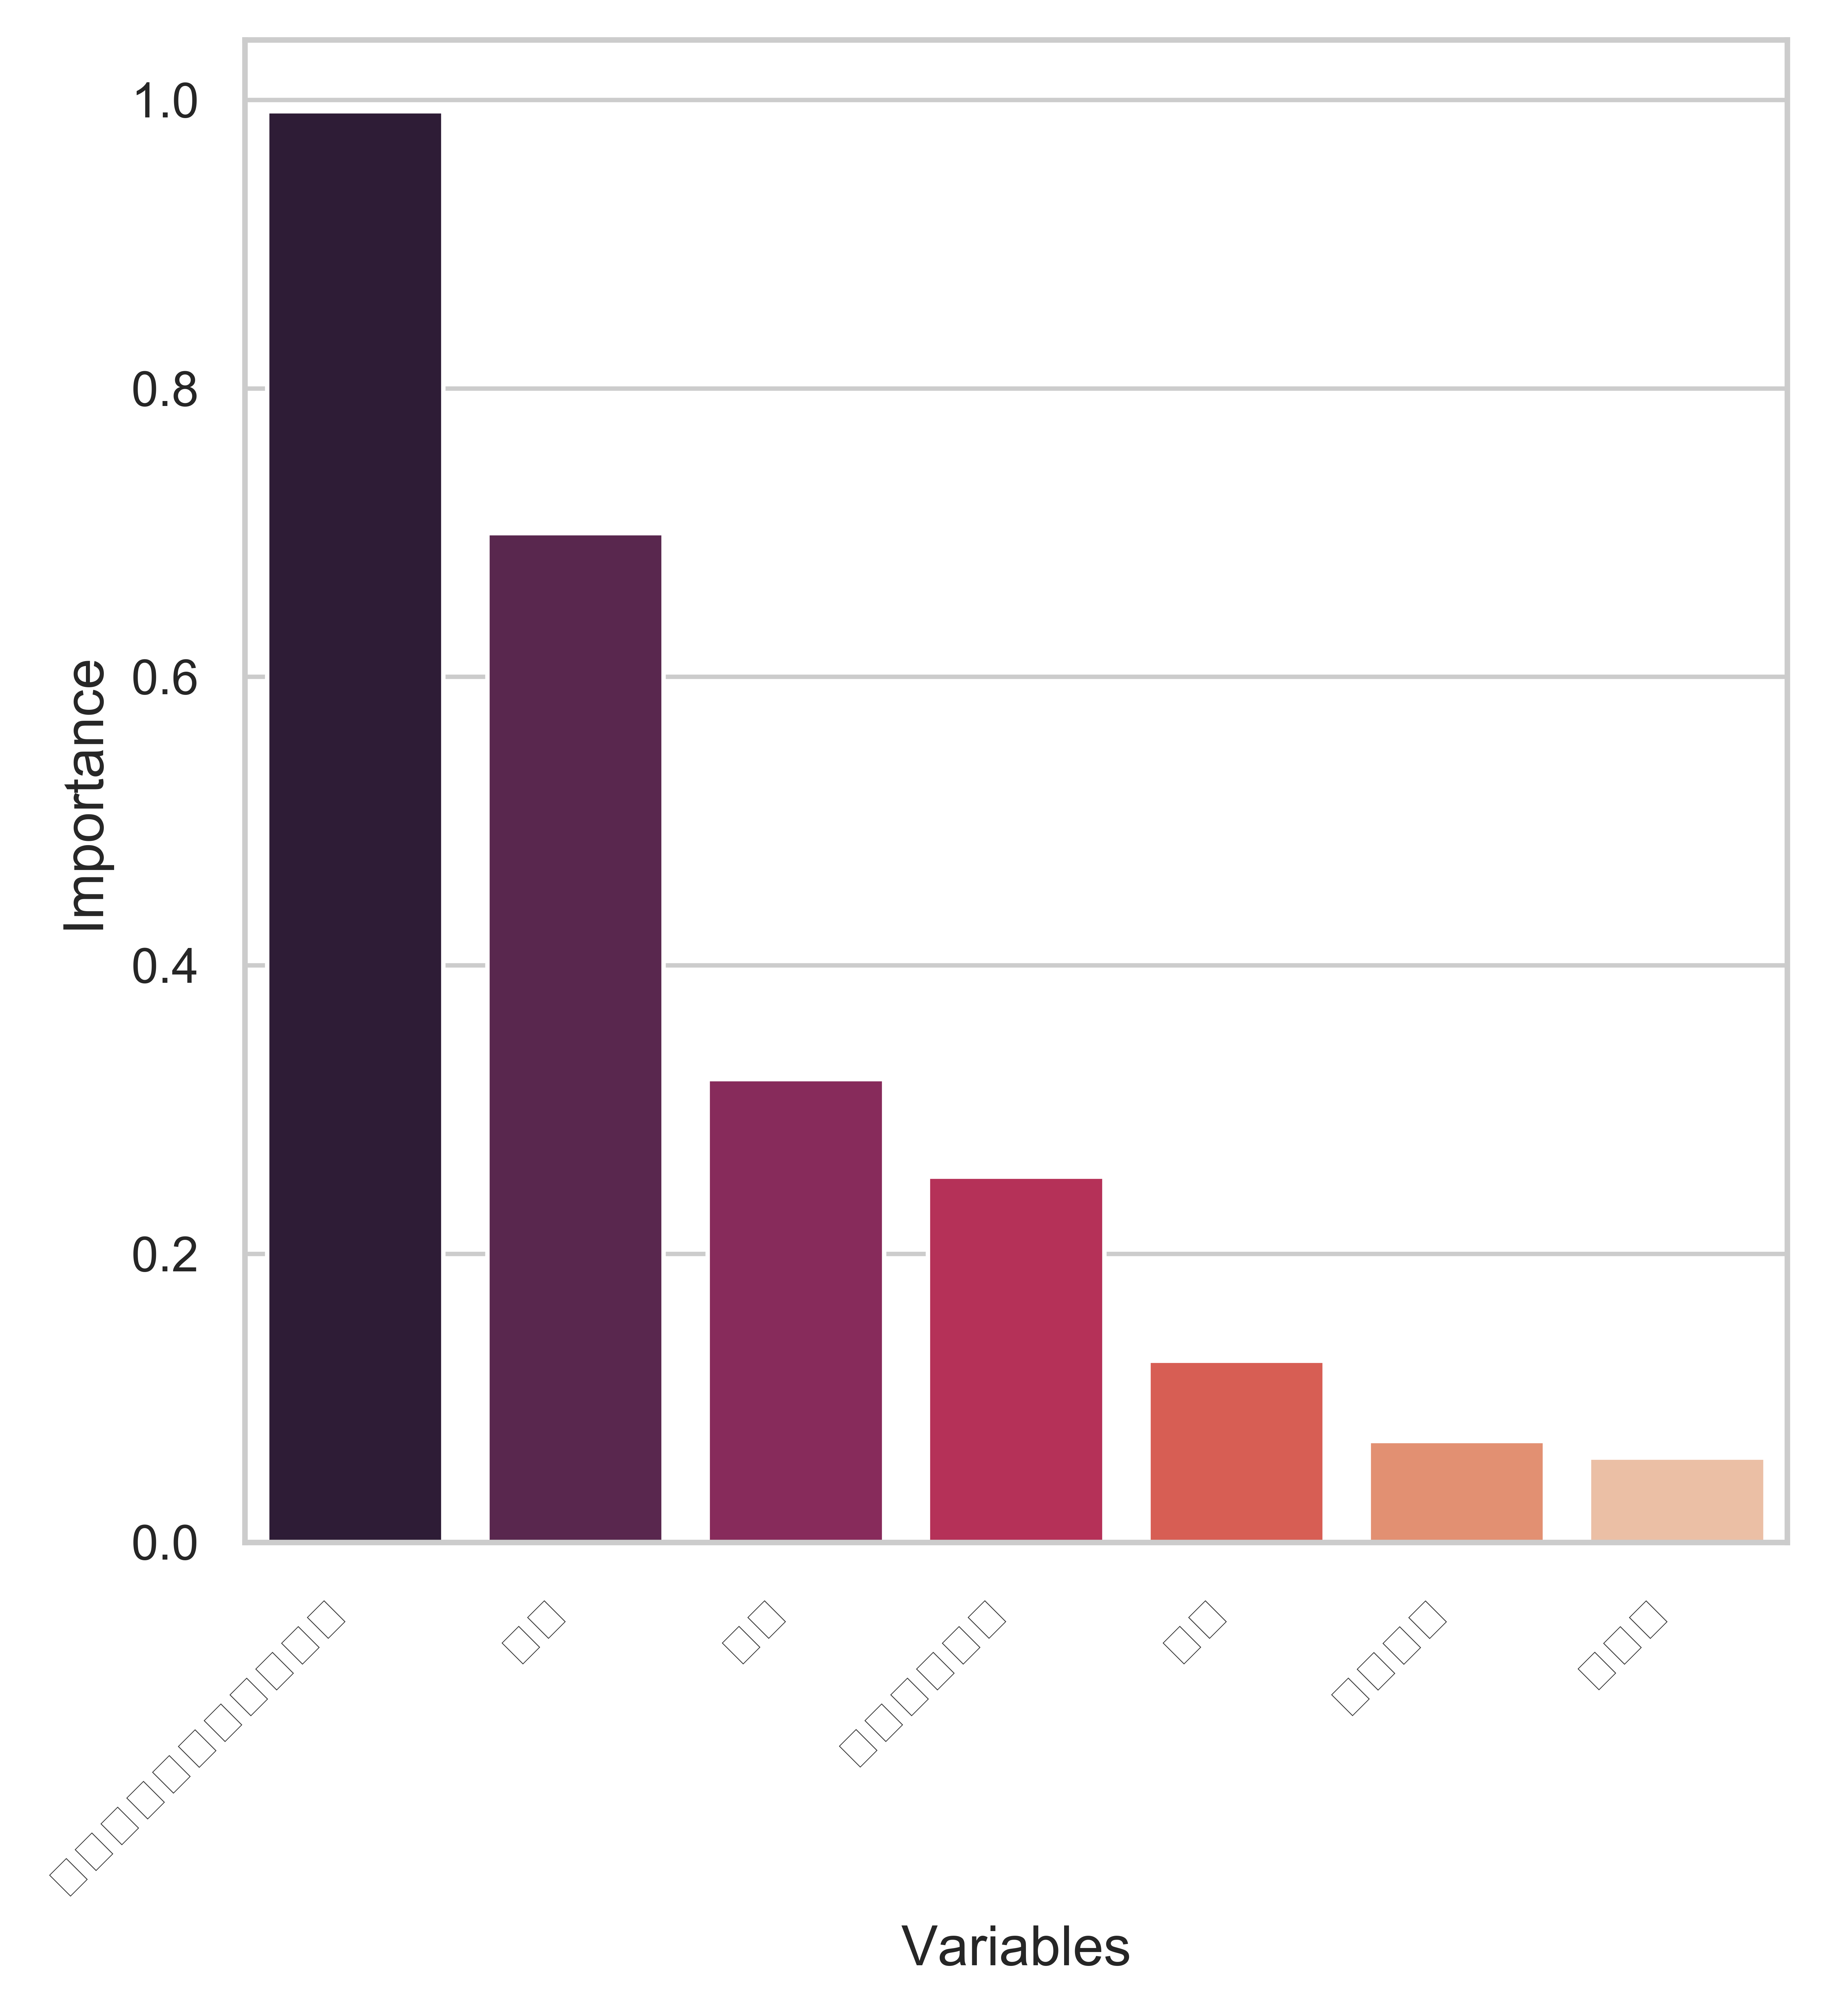

<Figure size 6000x6000 with 0 Axes>

In [89]:
# feature importance
# use short name for display in figure
FEATURE_NAME_MAPPING = {
    '年龄': '年龄' , 
    '孕次':'孕次', 
    '产次':'产次', 
    '色谱法同型半胱氨酸测定': '色谱法同型半胱氨酸测定', 
    '剖宫产次':'剖宫产次', 
    '自然流产次数':'自然流产次数', 
    '顺产次':'顺产次'}
feature_importance = pd.DataFrame()
feature_importance['Variables_name'] = SIGNIFICANT_X
feature_importance["Variables"]=[FEATURE_NAME_MAPPING[i] for i in SIGNIFICANT_X]
feature_importance['Importance'] = 0

for i in range(100):
    classifier = XGBClassifier(**METHODS[1]["hyper_parameters"],random_state=SEED+i)
    t_X_train, _, t_y_train, _ = train_test_split(X_train, y_train, test_size=0.3,
                                                  random_state=SEED + i)
    classifier.fit(t_X_train, t_y_train)
    shap_values = shap.TreeExplainer(classifier).shap_values(t_X_train[SIGNIFICANT_X], y=t_y_train[y], check_additivity=True)
    mean_shap = abs(shap_values).mean(0)
    feature_importance['Importance'] = feature_importance['Importance'] + mean_shap / 100

feature_importance = feature_importance.sort_values(axis=0, ascending=False, by='Importance')
display(feature_importance)
feature_importance.to_csv("./feature_importance.csv")


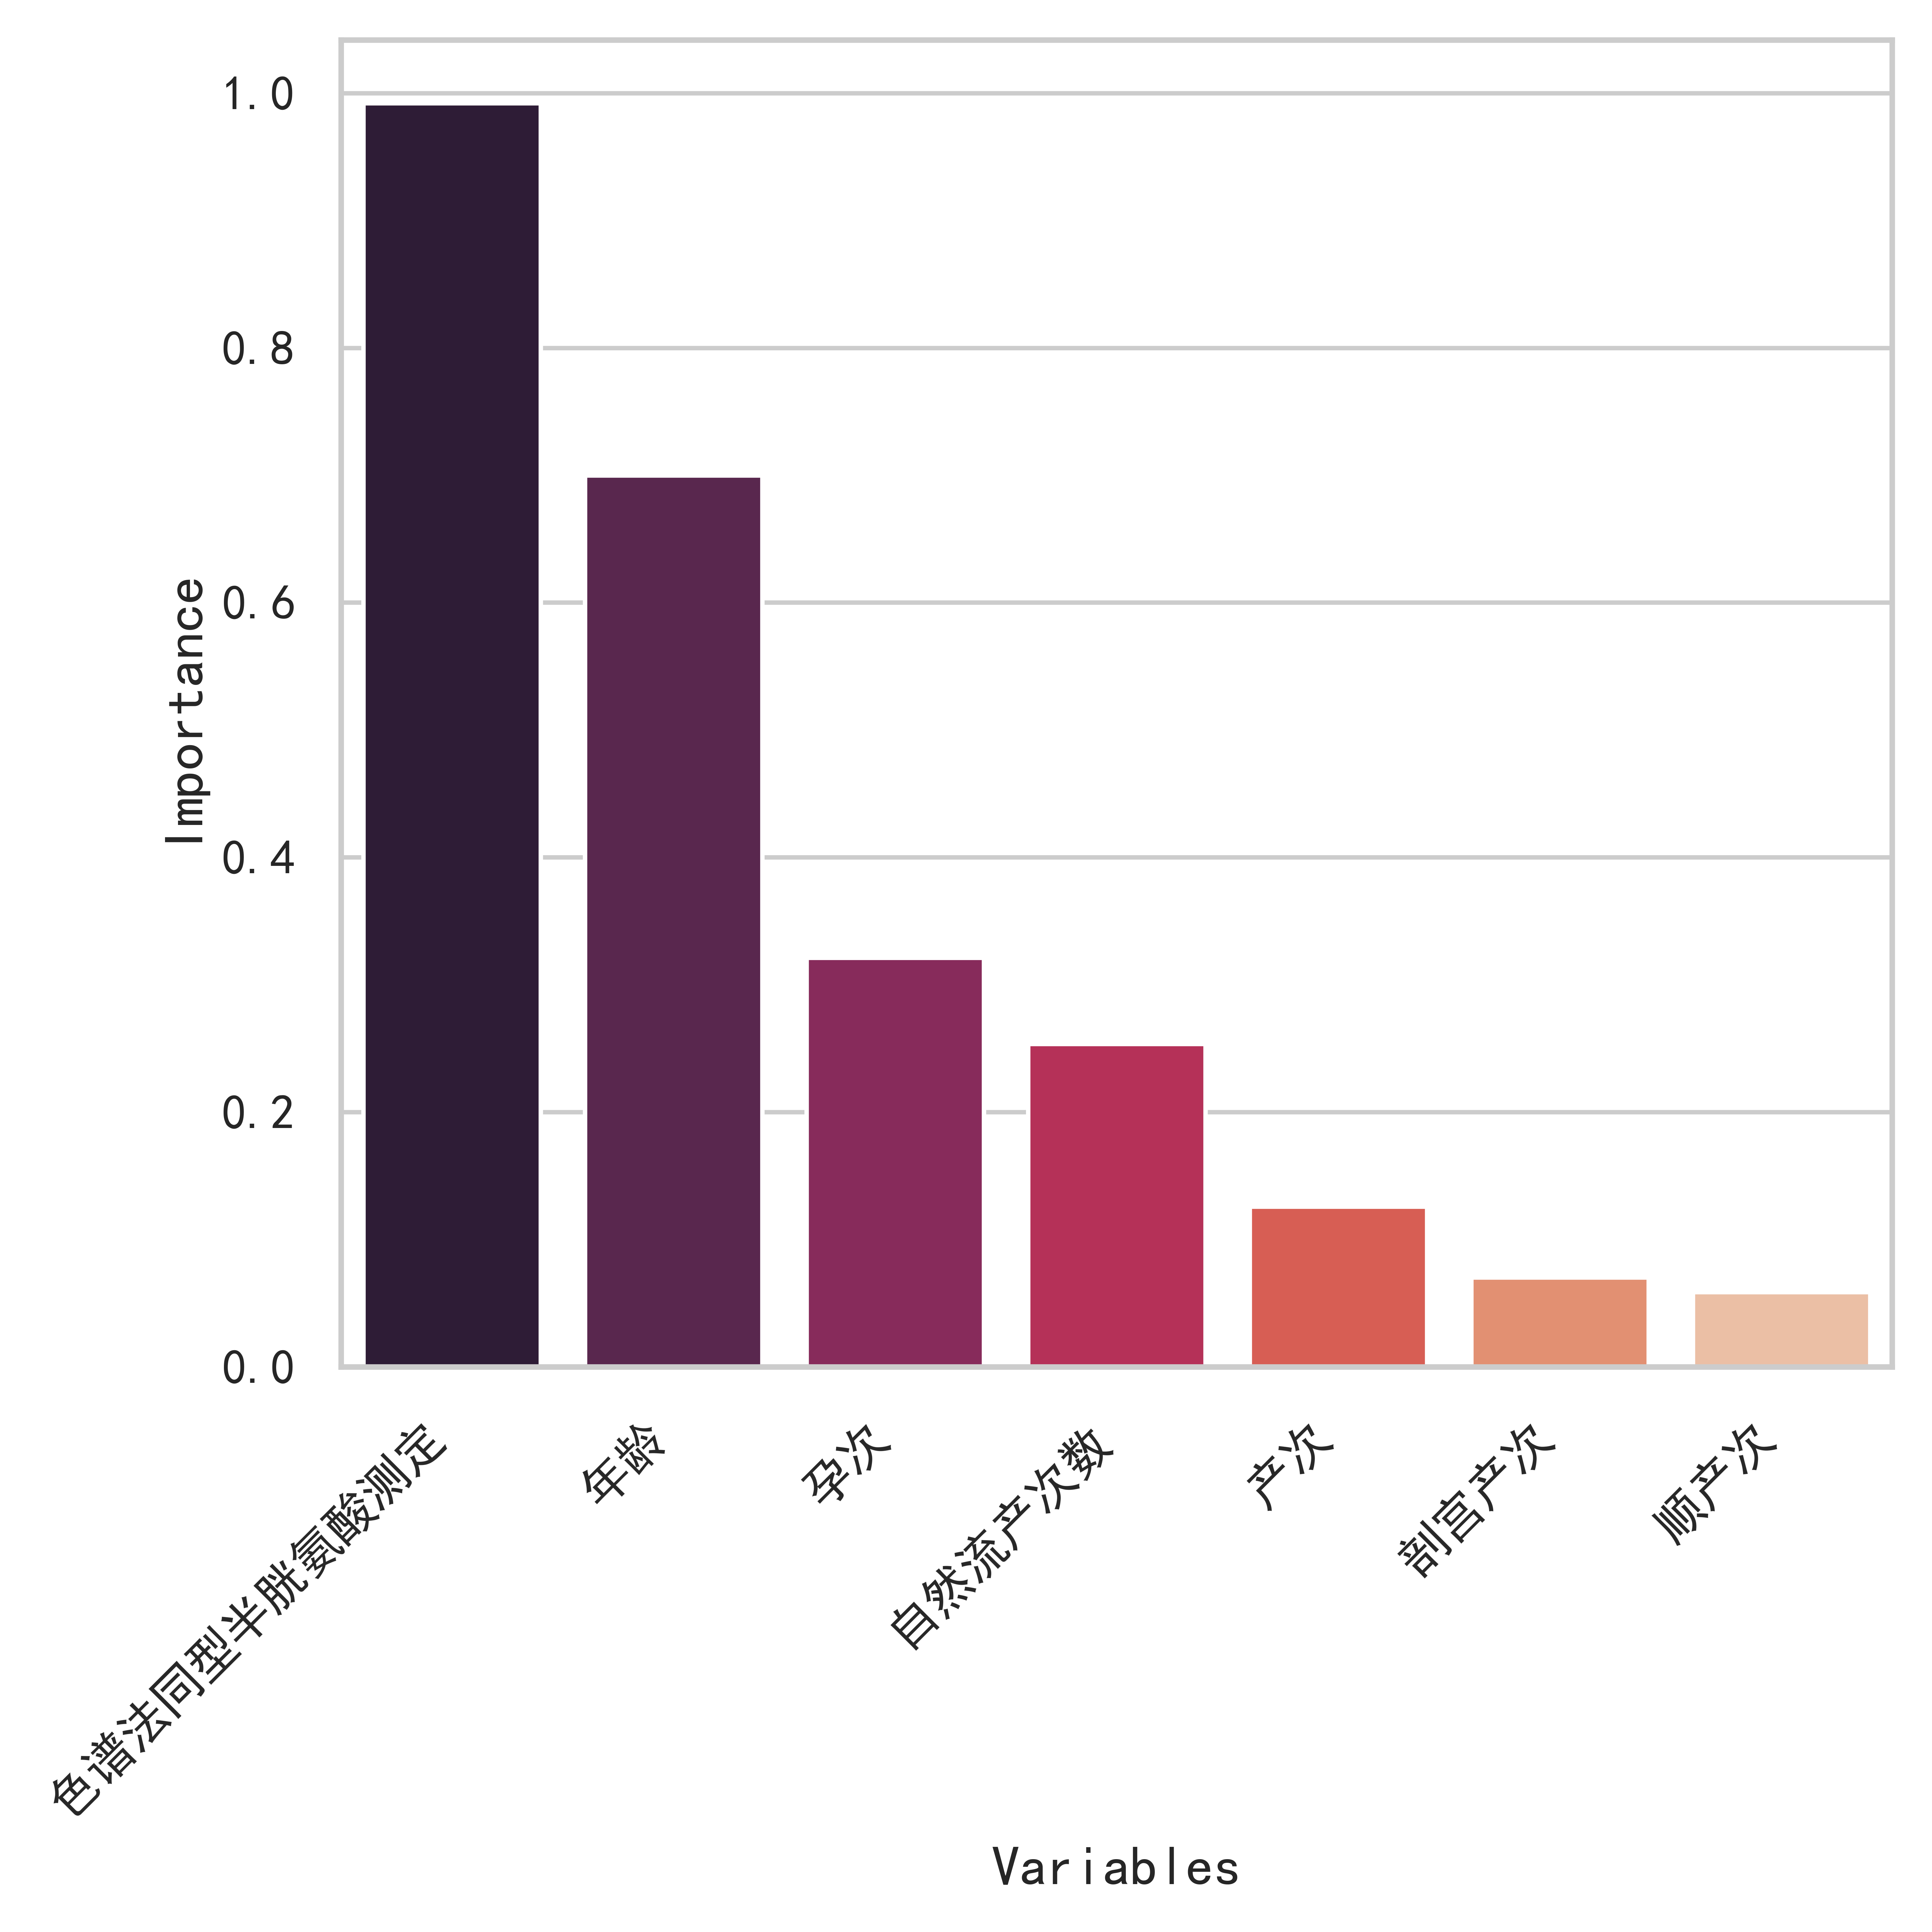

In [91]:
importance_plot=sns.barplot(x="Variables", y="Importance",palette="rocket",data=feature_importance)
importance_plot.set_xticklabels(
    importance_plot.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# plt.show()
plt.tight_layout()
plt.savefig("./Feature Importance.png")
# Image(filename="./paper/Figure_1.png")
# plt.clf()
# plt.close()    


### Generating

In [93]:
benchmark_result = pd.DataFrame()
reg_X = []
for i in tqdm(range(len(feature_importance))):

    reg_X.append(feature_importance['Variables_name'].values[i])
    if not (len(reg_X) in VAR_NUM):
        continue

    for method in METHODS:
        if method["name"] in COMPARED_METHOD:
            # one_model_result stores the result of a combination of classifier and vars, e.g. 4 variables exgboost performance
            one_model_result = {
                "num": i + 1, # the number of used variables
                "method": method["name"], # the name of classifier
                "external": True, # test set or cross-validation test(validation) set
                "reg_X": json.dumps(reg_X),
            }
            classifier = method["classifier"](**method["hyper_parameters"])
            classifier.fit(X_train[reg_X], y_train)

            # save tmp result for later analysis
            if method["name"]=="XGBoost":
                shap_values = shap.TreeExplainer(classifier).shap_values(X_test[reg_X], y=y_test[y], check_additivity=True)
                with open("./tmp/{}_SHAP_{}.pkl".format(method["name"], len(reg_X)), "wb") as f:
                    pickle.dump([shap_values, X_test[reg_X], reg_X], file=f)

            y_pred_test_external = classifier.predict(X_test[reg_X])
            y_pred_train_external = classifier.predict(X_train[reg_X])

            for k, v in MY_METRICS.items():
                one_model_result[k + "_test"] = v(y_test, y_pred_test_external)
                one_model_result[k + "_train"] = v(y_train, y_pred_train_external)

            # some METHODS dont have auc
            if method["name"] in HAVE_AUC_METHOD:
                y_pred_prob_test_external = classifier.predict_proba(X_test[reg_X])
                y_pred_prob_train_external = classifier.predict_proba(X_train[reg_X])
                # save roc result for later analysis
                with open("./tmp/{}_ROC_{}.pkl".format(method["name"], len(reg_X)), "wb") as f:
                    pickle.dump(roc_curve(y_test, y_pred_prob_test_external[:, 1]), file=f)

                for k, v in {
                    "AUC_macro": partial(roc_auc_score, average="macro"),
                }.items():
                    one_model_result[k + "_test"] = v(y_test, y_pred_prob_test_external[:, 1])
                    one_model_result[k + "_train"] = v(y_train, y_pred_prob_train_external[:, 1])
            benchmark_result = benchmark_result.append(one_model_result, ignore_index=True)

            # CV TEST RESULT
            if RUN_CV_RESULT:
                for j in range(CV_RESULT_REPEAT):
                    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=j * 9)
                    for train_index, test_index in kfold.split(X_train[reg_X], y_train[[y]]):

                        t_X_train, t_X_test = X_train[reg_X].iloc[train_index], X_train[reg_X].iloc[test_index]
                        t_y_train, t_y_test = y_train[[y]].iloc[train_index], y_train[[y]].iloc[test_index]

                        classifier = method["classifier"](**method["hyper_parameters"])
                        classifier.fit(t_X_train, t_y_train)
                        t_y_pred_test_CV = classifier.predict(t_X_test)
                        t_y_pred_train_CV = classifier.predict(t_X_train)

                        one_model_result = {"num": i + 1, "method": method["name"], "external": False, "reg_X": json.dumps(reg_X)}
                        for k, v in MY_METRICS.items():
                            one_model_result[k + "_test"] = v(t_y_test, t_y_pred_test_CV)
                            one_model_result[k + "_train"] = v(t_y_train, t_y_pred_train_CV)
                        if method["name"] in HAVE_AUC_METHOD:
                            t_y_pred_prob_test_CV = classifier.predict_proba(t_X_test)
                            t_y_pred_prob_train_CV = classifier.predict_proba(t_X_train)

                            for k, v in {
                                "AUC_macro": partial(roc_auc_score, average="macro"),
                            }.items():
                                one_model_result[k + "_test"] = v(t_y_test, t_y_pred_prob_test_CV[:, 1])
                                one_model_result[k + "_train"] = v(t_y_train, t_y_pred_prob_train_CV[:, 1])

                        benchmark_result = benchmark_result.append(one_model_result, ignore_index=True)

# too large to display
# display(benchmark_result)
benchmark_result.to_csv(".benchmark.csv")
pivot_benchmark_result=benchmark_result.pivot_table(
    values=
    [
        "AUC_macro_test",
        "F1_weighted_test",
        "Accuracy_test",
        "Sensitivity_test",
        "Specifity_test",
    ],
    aggfunc=[np.mean, np.std],
    columns=["external", "method"],
    index=["num"])
display(pivot_benchmark_result)
pivot_benchmark_result.to_csv(".benchmark_pivot.csv")


[11:23:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:09] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

mean                                              \
         AUC_macro_test                                               
external            0.0                                               
method    Decision Tree       LDA  Logistic Random Forest   XGBoost   
num                                                                   
1.0            0.551290  0.571884  0.571884      0.540997  0.563741   
2.0            0.612271  0.592185  0.594696      0.543463  0.618077   
3.0            0.623879  0.603816  0.605254      0.577962  0.630471   
4.0            0.615154  0.598003  0.599331      0.588357  0.628878   
5.0            0.615589  0.594022  0.595375      0.592838  0.625865   
6.0            0.614113  0.591473  0.593349      0.586649  0.625912   
7.0            0.614106  0.587432  0.589736      0.583003  0.622615   

                                                                    ...  \
                                                                    ...   
external           1.0                                              ...   
method   Decision Tree       LDA  Logistic Random Forest   XGBoost  ...   
num                                                                 ...   
1.0           0.542735  0.535028  0.535028      0.581744  0.548104  ...   
2.0           0.547374  0.635912  0.636716      0.582219  0.563445  ...   
3.0           0.551903  0.622507  0.623311      0.569728  0.579151  ...   
4.0           0.551903  0.623347  0.624443      0.580795  0.576448  ...   
5.0           0.549529  0.623201  0.623639      0.560231  0.587954  ...   
6.0           0.549529  0.625539  0.625977      0.564504  0.596830  ...   
7.0           0.549529  0.625466  0.626196      0.572759  0.591606  ...   

                      std                                                   \
         Sensitivity_test                                   Specifity_test   
external              0.0                                              0.0   
method           Logistic Random Forest       SVM   XGBoost  Decision Tree   
num                                                                          
1.0              0.000000      0.049595  0.005203  0.000000       0.062930   
2.0              0.021515      0.054616  0.019894  0.000000       0.074524   
3.0              0.029443      0.047532  0.026362  0.003728       0.075024   
4.0              0.030320      0.047436  0.025397  0.004867       0.074618   
5.0              0.032195      0.047317  0.031212  0.004455       0.077431   
6.0              0.031219      0.044849  0.036500  0.006282       0.072874   
7.0              0.032539      0.047798  0.039983  0.005218       0.072948   

                                                                
                                                                
external                                                        
method         LDA  Logistic Random Forest       SVM   XGBoost  
num                                                             
1.0       0.000000  0.000000      0.070694  0.000000  0.000000  
2.0       0.046740  0.045746      0.063553  0.051021  0.000000  
3.0       0.044220  0.043594      0.070119  0.048004  0.000000  
4.0       0.046894  0.045797      0.064334  0.048152  0.002354  
5.0       0.046549  0.047161      0.065747  0.049384  0.004044  
6.0       0.048699  0.044911      0.065570  0.047693  0.005674  
7.0       0.046553  0.043856      0.063891  0.049920  0.006489  

[7 rows x 87 columns]

In [2]:
for i in [4,12]:
    table=benchmark_result[(benchmark_result.external==1) & (benchmark_result.num==i)].pivot_table(
        values=
        [
            "AUC_macro_test",
            "F1_weighted_test",
            "Accuracy_test",
            "Sensitivity_test",
            "Specifity_test",
        ],
        aggfunc=[np.mean],
        index=["method"])["mean"].T
    table.to_csv("./Table_{}.csv".format({4:4,12:3}[i]))
    display(table)
# slightly different(<1%) with paper because of randomness, but the ranking among methods as well as analysis remain the same


NameError: name 'benchmark_result' is not defined